<a href="https://csdms.colorado.edu/wiki/ESPIn2020"><img style="float: center; width: 75%" src="../../../media/ESPIn.png"></a>

# Introduction to Landlab: Grids, Landlab as a solver for advection-diffusion problems, some demos

This tutorial illustrates how you can use Landlab to construct a simple two-dimensional numerical model on a regular (raster) grid, using a simple forward-time, centered-space / upwind numerical scheme. 

### *Use Landlab to solve the eyjafjallajökull problem*

#### Preparation: 

load the map of Europe, plot the location of the eyjafjallajökull and Brussels

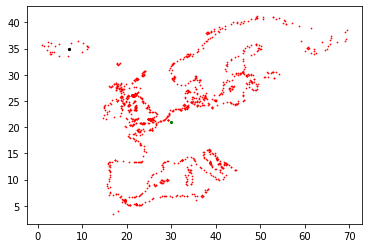

In [1]:
import numpy as np
from matplotlib import pyplot as plt

EU_coast = np.loadtxt('../../../data/EuropePoints_xp25_ym30.csv', delimiter=',')
vol_y = 35
vol_x = 7
Br_y = 21
Br_x = 30

plt.figure()
plt.scatter(EU_coast[:,0],EU_coast[:,1],s=0.5,c='r')
plt.scatter(vol_x,vol_y,s=5,c='k')
plt.scatter(Br_x,Br_y,s=5,c='g')

(2b .1) Create an instance of a `RasterModelGrid` called `EU`, with 100 rows and 140 columns, with a spacing between nodes of 0.5 degrees (1 degree = ca. 111 km). Calculate the index of the eyjafjallajökull and Brussels within the grid

In [3]:
# (enter your solution to 2b.1 here)
rows = 100
cols = 140
dx = 0.5 # in degrees
# xy spacing in degrees (ca. 111 km)
from landlab import RasterModelGrid
EU = RasterModelGrid((rows, cols), xy_spacing=dx)

vol_loc = int(vol_y/dx*cols+vol_x/dx)
Br_loc = int(Br_y/dx*cols+Br_x/dx)

(2b.2) Query the grid variables `number_of_nodes` and `number_of_core_nodes` to find out how many nodes are in your grid, and how many of them are core nodes.

In [4]:
# (enter your solution to 2b.2 here)
print(EU.number_of_nodes)
print(EU.number_of_core_nodes)

14000
13524


(2b.3) Add a new field to your grid, called `Aerosol` and attached to nodes. Have the initial values be all zero.

In [5]:
# (enter your solution to 2b.3 here)

(2b.4) Change the Aerosol concentration at the eyjafjallajökull to an initial concentration of 10 ppm (store this value in `C_ini`) . Use the `imshow_grid` function to display a shaded image of the Aerosol field.

In [7]:
# (enter your solution to 2b.4 here)

(2b.5) Now lets do some more advanced plotting. Use the `imshow_grid` function to to plot the Aerosol concentration, but this time plot all cells with Aerosol concentrations smaller than 1 ppm as white transparent pixels. To do this, make a copy of the Aerosol field and mask it [see ](https://numpy.org/doc/stable/reference/maskedarray.generic.html). Hint: try using `np.ma.masked_where(..., ...)`. Use the inferno_r colormap (see cmap argument of `imshow_grid`). On top of the concentration field, plot the map of Europe using the statements from the preparation cell above and the EU_coast variable. 

Finally, make a function out of this plotting code snippet so that you can easily reuse it later 

/Users/beca4397/opt/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:269: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno_r").copy()
  cmap.set_bad(alpha=0.0)


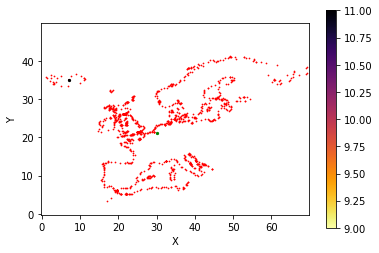

In [8]:
def plot_aerosol(a):
    a_plt = np.zeros_like(a)
    a_plt[:] = a
    a_plt = np.ma.masked_where(a_plt <1, a_plt)
    imshow_grid(EU,a_plt,cmap ='inferno_r',color_for_background=None, color_for_closed=None)        
    plt.scatter(EU_coast[:,0],EU_coast[:,1],s=0.5,c='r')
    plt.scatter(vol_x,vol_y,s=5,c='k')
    plt.scatter(Br_x,Br_y,s=5,c='g')        
    plt.show()
    
plot_aerosol(a)

Define some constants: 
- $C_n$ (source term): amount of dust particles produced per day (20 ppm/day)
- $D$ (diffusion constant) : 1.5  deg$^2$  day$^-1$
- $dt$ (in days, see stability rule before)
- get $dx$ and $dy$ from landlab grid
- totT: the total amount of iterations, see to 1000 for now
- create an empty np array to store the aerosol concentration above Brussels during the model run (with size totT)

In [9]:
C_n = 200
D  = 1.5
dx = EU.dx
dy = EU.dy
dt= 0.245 * EU.dx * EU.dx / D
totT = 1000
Br_out = np.zeros(totT)
time = np.arange(start=0,stop = totT, step = 1)*dt


- Create a new field of zeros called aerosol_flux and attached to links. Using the 'number_of_links' grid property, verify that your new field array has the correct number of items. 

In [10]:
qa = EU.add_zeros('aerosol_flux', at='link')
print(EU.number_of_links)
print(len(qa))

27760
27760


Boundary conditions: for this example, we'll assume that all sides are  are open. (The order of the function arguments is east, north, west, south). This is the default configuration. LAter on we will check what happens if boundary conditions are open. 

In [11]:
EU.set_closed_boundaries_at_grid_edges(True, True, True, True)

*A note on boundaries:* with a Landlab raster grid, all the perimeter nodes are boundary nodes. In this example, there are 98 + 140 + 98 + 140 = 476 boundary nodes. All the remaining nodes are known as **core** nodes. In this example, there are 100*140-476 = 13524 core nodes:

In [12]:
len(EU.boundary_nodes)
# len(EU.core_nodes)
100*140-476

13524

(2b.7) Now solve the 2D diffusion equation. Loop through totT iterations, representing $totT*dt$ days. On each pass through the loop, we do the following:

1. Calculate, and store in the array `g`, the **aerosol gradient** between each neighboring pair of nodes. The gradient value is a positive number when the gradient is "uphill" in the direction of the link, and negative when the gradient is "downhill" in the direction of the link. On a raster grid, link directions are always in the direction of increasing 𝑥 ("horizontal" links) or increasing 𝑦 ("vertical" links).

2. Calculate, and store in the array `qa`, the **aerosol flux** between each adjacent pair of nodes by multiplying their gradient by the transport coefficient. We will only do this for the active links (those not connected to a closed boundary, and not connecting two boundary nodes of any type); others will remain as zero.

3. Calculate the resulting net flux at each node, (positive=net outflux, negative=net influx). The negative of this array is the rate of change of elevation at each (core) node, so store it in a node array called `dadt'.

4. Update the aerosol concentrations for the new time step.

5. Take care of the source term: calculate the amount of ash being produced during one timestep and add this to the aerosol field at the volcano location

5. Store the concentration above Brussels in the `Br_out` array

6. Plot the resulting concentration every 100 iterations 

~~~ python
 for i in range(totT):  
     g = 
     qa[EU.active_links] = 
     dadt = 
     a[EU.core_nodes] += dadt[EU.core_nodes] * dt   
     a[vol_loc] += C_n*dt
     Br_out[i] = a[Br_loc]       
     if i%100==0:     
         print('Time is : ' + str(i*dt) + 'days')
         plot_aerosol(a)      
~~~


Plot the concentration through time at Brussels

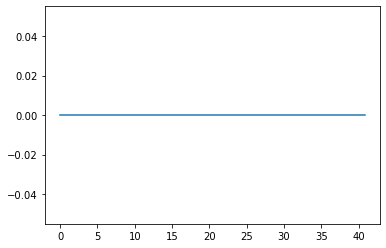

In [13]:
plt.figure()
plt.plot(time,Br_out)

* What happens if you set all of the boundaries as closed boundaries? 

## Advection diffusion: 
We have solved the diffusion part of the volcanic ash problem imposed by the eyjafjallajökull volcano. However, most of the ash transport was induced by wind fields advection the ash towards Europe (yup, west winds). Can you come up with a landlab implementation of the advection equation? Copy paste your solution from exercise () and add some lines to solve the 2D advection equation:

$$\frac{\partial C}{\partial t} +v \frac{\partial C}{\partial x} +u \frac{\partial C}{\partial y}=0
\label{eq:1}\tag{1}$$
where $C$ is the aerosol concentration and $v$ is a constant windspeed at which aerosol concentrations are advectected in the x direction and $u$ is a constant windspeed at which aerosol concentrations are advectected in the y direction.

You will need some additional variables: 
- $v$ (horizontal wind speed, positive in x direction): 1.5 deg/day
- $u$ (vertical wind speed, positive in y direction): -0.75 deg/day

- Hint 1: reset the Aerosol field (a)
- Hint 2: update the time criterion and combine the diffusion and the advection criteria 
- Hint 3: currently, the landlab grid library has no predefined functions to calculate advection (no equivalent for calc_flux_div_at_node which is used to solve the heat eq.). Hence, you will have to discretise the advection equation yourself using an upwind first order FDM, but using the matlab node/link structure. To calculate the links at every node, use `links_at_node`
- Hint 4: given that there is no predefined method to calculate advection, you will also have to take care of the boundary conditions. Assume open boundary nodes by setting the aerosol concentration at all boundary nodes to 0 ppm at the end of every iteration. Use `grid.boundary_nodes`.

~~~ python 
v = 1.5
u = -.5
C_n = 200
D  = 1.5
dx = EU.dx
dy = EU.dy
totT = 1000
Br_out = np.zeros(totT)
time = np.arange(start=0,stop = totT, step = 1)*dt

a[:] = np.zeros_like(a)
g = np.zeros(EU.number_of_links)
dadt = np.zeros(EU.number_of_nodes)


dt_a = 0.95*np.minimum(dx/abs(v),dy/abs(u))
dt_d = 0.245 * dx * dx / D
dt = min(dt_a,dt_d)

rt = EU.links_at_node[0:len(a)][:,0]
up = EU.links_at_node[0:len(a)][:,1]
lt = EU.links_at_node[0:len(a)][:,2]
dw = EU.links_at_node[0:len(a)][:,3] 

for i in range(totT):  
    EU.calc_grad_at_link(a,out=g)
    qa[EU.active_links] = ...
    EU.calc_flux_div_at_node(qa,out=dadt)
    a[EU.core_nodes] -= ...
    
    # Advection 
    # horizontal (x) direction
    EU.calc_grad_at_link(a,out=g)    
    if v<0:
        a -= v*g[rt]*dt
    else:             
        a -= ...
    
    # vertical (y) direction
    EU.calc_grad_at_link(a,out=g)
    if u<0:
        a -= ...
    else:
        a -= u*g[dw]*dt
    
    # Or shorter: 
#     EU.calc_grad_at_link(a,out=g)   
#     a -= (v*g[rt]*(v<0) + v*g[lt]*(v>0))*dt
#     EU.calc_grad_at_link(a,out=g)
#     a -= (u*g[up]*(u<0) + u*g[dw]*(u>0))*dt
    
    # Source term   
    a[vol_loc] += C_n*dt
    
    # Keep track of concentration in Brussels
    Br_out[i] = a[Br_loc]
    
    #BC    
    a[EU.boundary_nodes] = 0 
    if i%100==0:     
        print('Time is : ' + str(i*dt) + 'days')
        plot_aerosol(a) 
        
plt.figure()
plt.plot(time,Br_out) 

~~~

* what happens if you change the vertical (u) velocity to  +0.25? 

Congratulations on making it to the end of this tutorial!

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>